# Alan's Benchmarking Report Pages

In [1]:
import pickle
import pandas as pd
import numpy as np
from importlib import reload
import sys

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util as bu
import graph_util as gu

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [2]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [3]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bu)  
reload(gu)

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bu.Util(df_raw, '../data/Other_Building_Data.xlsx')

## Set Site ID for All of the Reports Below & Start Data Dictionary for Template

In [4]:
site = 'ANSBG1'

In [101]:
template_data = {}

## DataFrame for "Energy Index Comparison" Report

In [5]:
# Need to have this constant at the top of the script in order to know what
# Fiscal Year to use in the Report.
FISCAL_YEAR_FOR_ONE_YEAR_REPORT = 2016

In [13]:
# Determine month count by year for Electricity to determine the latest
# complete year.
electric_only = df.query("service_type == 'Electricity'")
electric_months_present = bu.months_present(electric_only)
electric_mo_count = bu.month_count(electric_months_present)
last_complete_year = max(electric_mo_count[electric_mo_count==12].index)
last_complete_year

2017

### Table 1

### Table 2

In [54]:
# Filter down to just the records of the targeted fiscal year
df1 = df.query('fiscal_year == @last_complete_year')
df1.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
158,03,Electricity,2016,7,Electricity charge,-,58.940738,62.0,0.000000,2017,1,0.000000
159,03,Electricity,2016,7,Electricity charge,kWh,8469.632126,31.0,19429.262673,2017,1,66.292644
160,03,Electricity,2016,8,Electricity charge,-,15.000000,21.0,0.000000,2017,2,0.000000
161,03,Electricity,2016,8,Electricity charge,kWh,5109.125683,72.0,23571.373950,2017,2,80.425528
162,03,Electricity,2016,9,Electricity charge,kWh,6077.898905,90.0,30614.394523,2017,3,104.456314


In [55]:
# Get Total Utility cost by building. This includes non-energy utilities as well.
df2 = df1.pivot_table(index='site_id', values=['cost'], aggfunc=np.sum)
df2.columns = ['total_cost']
df2.head()

,total_cost
site_id,
03,99176.042407
04,105988.237749
05,546259.617195
06,100363.785597
07,107438.320632


In [56]:
# Save this into the Final DataFrame that we will build up as we go.
df_final = df2.copy()

In [57]:
# Get a list of the Energy Services and restrict the data to
# just these services
energy_svcs = bu.missing_energy_services([])
df2 = df1.query('service_type == @energy_svcs')
df2.service_type.unique()

array(['Electricity', 'Natural Gas', 'Oil #1', 'Steam'], dtype=object)

In [58]:
# Summarize Cost by Service Type
df3 = pd.pivot_table(df2, index='site_id', columns='service_type', values='cost', aggfunc=np.sum)
df3.head()

service_type,Electricity,Natural Gas,Oil #1,Steam
site_id,,,,
03,75242.720323,517.528982,17433.66,NaN
04,84839.201398,1016.329788,9308.85,NaN
05,361988.694070,NaN,NaN,132582.139643
06,76683.320968,588.228982,8094.94,NaN
07,87312.574743,637.478982,4187.77,NaN


In [59]:
# Change column names
cols = ['{}_cost'.format(bu.change_name(col)) for col in df3.columns]
df3.columns = cols
df3.head()

,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost
site_id,,,,
03,75242.720323,517.528982,17433.66,NaN
04,84839.201398,1016.329788,9308.85,NaN
05,361988.694070,NaN,NaN,132582.139643
06,76683.320968,588.228982,8094.94,NaN
07,87312.574743,637.478982,4187.77,NaN


In [60]:
# Add a total energy cost column
df3['total_energy_cost'] = df3.sum(axis=1)
df3.head()

,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost
site_id,,,,,
03,75242.720323,517.528982,17433.66,NaN,93193.909304
04,84839.201398,1016.329788,9308.85,NaN,95164.381186
05,361988.694070,NaN,NaN,132582.139643,494570.833713
06,76683.320968,588.228982,8094.94,NaN,85366.489950
07,87312.574743,637.478982,4187.77,NaN,92137.823725


In [61]:
# Add a total Heat Cost Column
df3['total_heat_cost'] = df3.total_energy_cost.fillna(0.0) - df3.electricity_cost.fillna(0.0)
df3.head()

,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost
site_id,,,,,,
03,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982
04,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788
05,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643
06,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982
07,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982


In [62]:
# Add this to the final DataFrame
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982


In [63]:
# Summarize MMBtu by Service Type
df3 = pd.pivot_table(df2, index='site_id', columns='service_type', values='mmbtu', aggfunc=np.sum)
df3.head()

service_type,Electricity,Natural Gas,Oil #1,Steam
site_id,,,,
03,1007.401282,0.000,1280.880,NaN
04,1364.770649,23.766,681.345,NaN
05,5576.480071,NaN,NaN,9357.875
06,1235.762563,0.816,985.095,NaN
07,1379.274312,0.306,302.670,NaN


In [64]:
# Change column names
cols = ['{}_mmbtu'.format(bu.change_name(col)) for col in df3.columns]
df3.columns = cols
df3.head()

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu
site_id,,,,
03,1007.401282,0.000,1280.880,NaN
04,1364.770649,23.766,681.345,NaN
05,5576.480071,NaN,NaN,9357.875
06,1235.762563,0.816,985.095,NaN
07,1379.274312,0.306,302.670,NaN


In [65]:
# Add a total mmbtu column
df3['total_mmbtu'] = df3.sum(axis=1)
df3.head()

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu
site_id,,,,,
03,1007.401282,0.000,1280.880,NaN,2288.281282
04,1364.770649,23.766,681.345,NaN,2069.881649
05,5576.480071,NaN,NaN,9357.875,14934.355071
06,1235.762563,0.816,985.095,NaN,2221.673563
07,1379.274312,0.306,302.670,NaN,1682.250312


In [66]:
# Add a total Heat mmbtu Column
df3['total_heat_mmbtu'] = df3.total_mmbtu.fillna(0.0) - df3.electricity_mmbtu.fillna(0.0)
df3.head()

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu,total_heat_mmbtu
site_id,,,,,,
03,1007.401282,0.000,1280.880,NaN,2288.281282,1280.880
04,1364.770649,23.766,681.345,NaN,2069.881649,705.111
05,5576.480071,NaN,NaN,9357.875,14934.355071,9357.875
06,1235.762563,0.816,985.095,NaN,2221.673563,985.911
07,1379.274312,0.306,302.670,NaN,1682.250312,302.976


In [67]:
# Add this to the final DataFrame
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu,total_heat_mmbtu
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982,1007.401282,0.000,1280.880,NaN,2288.281282,1280.880
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788,1364.770649,23.766,681.345,NaN,2069.881649,705.111
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643,5576.480071,NaN,NaN,9357.875,14934.355071,9357.875
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982,1235.762563,0.816,985.095,NaN,2221.673563,985.911
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982,1379.274312,0.306,302.670,NaN,1682.250312,302.976


In [68]:
# Electricity kWh summed by building
df3 = pd.pivot_table(df2.query('units == "kWh"'), index='site_id', values='usage', aggfunc=np.sum)
df3.columns = ['electricity_kwh']
df3.head()

,electricity_kwh
site_id,
03,2.952524e+05
04,3.999914e+05
05,1.634373e+06
06,3.621813e+05
07,4.042422e+05


In [69]:
# Include in Final DF
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu,total_heat_mmbtu,electricity_kwh
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982,1007.401282,0.000,1280.880,NaN,2288.281282,1280.880,2.952524e+05
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788,1364.770649,23.766,681.345,NaN,2069.881649,705.111,3.999914e+05
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643,5576.480071,NaN,NaN,9357.875,14934.355071,9357.875,1.634373e+06
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982,1235.762563,0.816,985.095,NaN,2221.673563,985.911,3.621813e+05
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982,1379.274312,0.306,302.670,NaN,1682.250312,302.976,4.042422e+05


In [70]:
# Electricity kW, both Average and Max by building
df3 = pd.pivot_table(df2.query('units == "kW"'), index='site_id', values='usage', aggfunc=[np.mean, np.max])
df3.columns = ['electricity_kw_average', 'electricity_kw_max']
df3.head()

,electricity_kw_average,electricity_kw_max
site_id,,
ASLELC1,96.774383,125.285595
ASLELC2,678.454329,7793.255542
BALHHW,78.843710,101.410714
BAOBG1,161.955333,218.038866
CACBG1,394.247915,496.671907


In [71]:
# Add into Final Frame
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu,total_heat_mmbtu,electricity_kwh,electricity_kw_average,electricity_kw_max
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982,1007.401282,0.000,1280.880,NaN,2288.281282,1280.880,2.952524e+05,NaN,NaN
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788,1364.770649,23.766,681.345,NaN,2069.881649,705.111,3.999914e+05,NaN,NaN
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643,5576.480071,NaN,NaN,9357.875,14934.355071,9357.875,1.634373e+06,NaN,NaN
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982,1235.762563,0.816,985.095,NaN,2221.673563,985.911,3.621813e+05,NaN,NaN
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982,1379.274312,0.306,302.670,NaN,1682.250312,302.976,4.042422e+05,NaN,NaN


In [72]:
# Check a building that has a kW charge
df_final.loc['BALHHW']

total_cost                151479.203004
electricity_cost          140264.698548
natural_gas_cost                    NaN
fuel_oil_cost               8512.862536
district_heat_cost                  NaN
total_energy_cost         148777.561084
total_heat_cost             8512.862536
electricity_mmbtu           2351.479959
natural_gas_mmbtu                   NaN
fuel_oil_mmbtu               605.109668
district_heat_mmbtu                 NaN
total_mmbtu                 2956.589627
total_heat_mmbtu             605.109668
electricity_kwh           689179.354839
electricity_kw_average        78.843710
electricity_kw_max           101.410714
Name: BALHHW, dtype: float64

In [73]:
# Add in Square footage info
df_bldg = ut.building_info_df()[['sq_ft']]
# Add into Final Frame.  I do a merge here so as not to bring
# in buildings from the building info spreadsheet that are not in this
# dataset; this dataset has been restricted to one year.

df_final = pd.merge(df_final, df_bldg, how='left', left_index=True, right_index=True)
df_final.head()


,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu,total_heat_mmbtu,electricity_kwh,electricity_kw_average,electricity_kw_max,sq_ft
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982,1007.401282,0.000,1280.880,NaN,2288.281282,1280.880,2.952524e+05,NaN,NaN,49210.0
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788,1364.770649,23.766,681.345,NaN,2069.881649,705.111,3.999914e+05,NaN,NaN,49210.0
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643,5576.480071,NaN,NaN,9357.875,14934.355071,9357.875,1.634373e+06,NaN,NaN,234412.0
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982,1235.762563,0.816,985.095,NaN,2221.673563,985.911,3.621813e+05,NaN,NaN,57047.0
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982,1379.274312,0.306,302.670,NaN,1682.250312,302.976,4.042422e+05,NaN,NaN,64699.0


In [74]:
# Build a DataFrame that has monthly degree days for each site/year/month
# combination.
combos = set(zip(df1.site_id, df1.fiscal_year, df1.fiscal_mo))
df_dd = pd.DataFrame(data=list(combos), columns=['site_id', 'fiscal_year', 'fiscal_mo'])
ut.add_degree_days_col(df_dd)

# Add up the degree days by site (we've already filtered down to one year or less
# of data.)
dd_series = df_dd.groupby('site_id').sum()['degree_days']
# Put in final DataFrame
df_final = pd.concat([df_final, dd_series], axis=1)
df_final.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_mmbtu,total_heat_mmbtu,electricity_kwh,electricity_kw_average,electricity_kw_max,sq_ft,degree_days
site_id,,,,,,,,,,,,,,,,,,
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982,1007.401282,0.000,1280.880,NaN,2288.281282,1280.880,2.952524e+05,NaN,NaN,49210.0,13802
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788,1364.770649,23.766,681.345,NaN,2069.881649,705.111,3.999914e+05,NaN,NaN,49210.0,13802
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643,5576.480071,NaN,NaN,9357.875,14934.355071,9357.875,1.634373e+06,NaN,NaN,234412.0,13802
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982,1235.762563,0.816,985.095,NaN,2221.673563,985.911,3.621813e+05,NaN,NaN,57047.0,13802
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982,1379.274312,0.306,302.670,NaN,1682.250312,302.976,4.042422e+05,NaN,NaN,64699.0,13802


In [76]:
# Calculate per square foot values for each building.
df_final['eui'] = df_final.total_mmbtu * 1e3 / df_final.sq_ft
df_final['eci'] = df_final.total_energy_cost / df_final.sq_ft
df_final['hdd_eui'] = df_final.total_heat_mmbtu * 1e6 / df_final.sq_ft / df_final.degree_days
df_final.to_csv('df_final.csv')
df_final.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,...,total_mmbtu,total_heat_mmbtu,electricity_kwh,electricity_kw_average,electricity_kw_max,sq_ft,degree_days,eui,eci,hdd_eui
site_id,,,,,,,,,,,,,,,,,,,,,
03,99176.042407,75242.720323,517.528982,17433.66,NaN,93193.909304,17951.188982,1007.401282,0.000,1280.880,...,2288.281282,1280.880,2.952524e+05,NaN,NaN,49210.0,13802,46.500331,1.893800,1.885876
04,105988.237749,84839.201398,1016.329788,9308.85,NaN,95164.381186,10325.179788,1364.770649,23.766,681.345,...,2069.881649,705.111,3.999914e+05,NaN,NaN,49210.0,13802,42.062216,1.933842,1.038155
05,546259.617195,361988.694070,NaN,NaN,132582.139643,494570.833713,132582.139643,5576.480071,NaN,NaN,...,14934.355071,9357.875,1.634373e+06,NaN,NaN,234412.0,13802,63.709857,2.109836,2.892380
06,100363.785597,76683.320968,588.228982,8094.94,NaN,85366.489950,8683.168982,1235.762563,0.816,985.095,...,2221.673563,985.911,3.621813e+05,NaN,NaN,57047.0,13802,38.944617,1.496424,1.252169
07,107438.320632,87312.574743,637.478982,4187.77,NaN,92137.823725,4825.248982,1379.274312,0.306,302.670,...,1682.250312,302.976,4.042422e+05,NaN,NaN,64699.0,13802,26.001179,1.424100,0.339288


In [80]:
# Get the totals across all buildings
totals_all_bldgs = df_final.sum()
# Total Degree-Days are not relevant
totals_all_bldgs.drop(['degree_days'], inplace=True)  # not relevant as it includes buildings that don't use heat

# Only use the set of buildings that have some energy use and non-zero
# square footage to determine EUI's and ECI's
energy_bldgs = df_final.query("total_mmbtu > 0 and sq_ft > 0")

# Get total square feet, energy use, and energy cost for these buildings
# and calculate EUI and ECI
sq_ft_energy_bldgs = energy_bldgs.sq_ft.sum()
energy_in_energy_bldgs = energy_bldgs.total_mmbtu.sum()
energy_cost_in_energy_bldgs = energy_bldgs.total_energy_cost.sum()
totals_all_bldgs['eui'] = energy_in_energy_bldgs * 1e3 / sq_ft_energy_bldgs
totals_all_bldgs['eci'] = energy_cost_in_energy_bldgs / sq_ft_energy_bldgs

# For calculating heating specific EUI, further filter the set of
# buildings down to those that have heating fuel use.
# Get separate square footage total and weighted average degree-day for these.
heat_bldgs = energy_bldgs.query("total_heat_mmbtu > 0")
heat_bldgs_sq_ft = heat_bldgs.sq_ft.sum()
heat_bldgs_heat_mmbtu = heat_bldgs.total_heat_mmbtu.sum()
heat_bldgs_degree_days = (heat_bldgs.total_heat_mmbtu * heat_bldgs.degree_days).sum() / heat_bldgs.total_heat_mmbtu.sum()
totals_all_bldgs['hdd_eui'] = heat_bldgs_heat_mmbtu * 1e6 / heat_bldgs_sq_ft / heat_bldgs_degree_days
totals_all_bldgs

total_cost                8.819777e+06
electricity_cost          6.223575e+06
natural_gas_cost          5.584942e+05
fuel_oil_cost             5.823540e+05
district_heat_cost        6.393009e+05
total_energy_cost         8.003724e+06
total_heat_cost           1.780149e+06
electricity_mmbtu         9.933530e+04
natural_gas_mmbtu         3.025849e+04
fuel_oil_mmbtu            4.222940e+04
district_heat_mmbtu       3.755807e+04
total_mmbtu               2.093813e+05
total_heat_mmbtu          1.100460e+05
electricity_kwh           2.911351e+07
electricity_kw_average    2.586110e+03
electricity_kw_max        1.433775e+04
sq_ft                     3.132384e+06
eui                       6.490046e+01
eci                       2.439388e+00
hdd_eui                   2.554333e+00
dtype: float64

In [81]:
# calculate a rank DataFrame
df_rank = pd.DataFrame()
for col in df_final.columns:
    df_rank[col] = df_final[col].rank(ascending=False)
df_rank.head()

,total_cost,electricity_cost,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_energy_cost,total_heat_cost,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,...,total_mmbtu,total_heat_mmbtu,electricity_kwh,electricity_kw_average,electricity_kw_max,sq_ft,degree_days,eui,eci,hdd_eui
site_id,,,,,,,,,,,,,,,,,,,,,
03,35.0,35.0,21.0,8.0,NaN,33.0,26.0,36.0,20.5,8.0,...,28.0,25.0,36.0,NaN,NaN,28.5,40.0,76.0,70.0,42.0
04,31.0,30.0,14.0,21.0,NaN,32.0,36.0,28.0,14.0,21.0,...,32.0,36.0,28.0,NaN,NaN,28.5,40.0,80.0,67.0,48.0
05,2.0,2.0,NaN,NaN,1.0,2.0,2.0,2.0,NaN,NaN,...,1.0,1.0,2.0,NaN,NaN,1.0,40.0,65.0,63.0,31.0
06,33.0,34.0,20.0,26.0,NaN,36.0,41.0,33.0,18.0,14.0,...,30.0,30.0,33.0,NaN,NaN,27.0,40.0,83.0,88.0,46.0
07,30.0,28.0,17.0,38.0,NaN,35.0,53.0,27.0,19.0,38.0,...,39.0,52.0,27.0,NaN,NaN,16.0,40.0,97.0,91.0,63.0


In [82]:
if site in df_final.index:
    # The site exists in the DataFrame
    site_info = df_final.loc[site]
    site_pct = site_info / totals_all_bldgs
    site_rank = df_rank.loc[site]
else:
    # Site is not there, probabaly because not present in this year.
    # Make variables with NaN values for all elements.
    site_info = df_final.iloc[0].copy()   # Just grab the first row to start with
    site_info[:] = np.NaN                 # Put 
    site_pct = site_info.copy()
    site_rank = sit_info.copy()
print(site_info, '\n')
print(site_pct, '\n')
print(site_rank, '\n')

total_cost                105418.750824
electricity_cost           54161.057879
natural_gas_cost           41955.989017
fuel_oil_cost                       NaN
district_heat_cost                  NaN
total_energy_cost          96117.046896
total_heat_cost            41955.989017
electricity_mmbtu            880.345629
natural_gas_mmbtu           2112.299698
fuel_oil_mmbtu                      NaN
district_heat_mmbtu                 NaN
total_mmbtu                 2992.645327
total_heat_mmbtu            2112.299698
electricity_kwh           258014.545455
electricity_kw_average              NaN
electricity_kw_max                  NaN
sq_ft                       6718.000000
degree_days                13802.000000
eui                          445.466705
eci                           14.307390
hdd_eui                       22.781038
Name: ANSBG1, dtype: float64 

degree_days                    NaN
district_heat_cost             NaN
district_heat_mmbtu            NaN
eci                     

In [58]:
# Make a final dictioary to hold all the results for this table
ei_data = {
    'bldg': site_info.to_dict(),
    'all': totals_all_bldgs.to_dict(),
    'pct': site_pct.to_dict(),
    'rank': site_rank.to_dict()
}

## DataFrame for "Utility Cost Overview" Report, Page 3

In [83]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'cost']]
df1.head()

,service_type,fiscal_year,fiscal_mo,cost
30353,Electricity,2006,12,739.280
30354,Electricity,2006,12,0.000
30355,Electricity,2006,12,183.065
30356,Electricity,2007,1,1414.275
30357,Electricity,2007,1,0.000


In [84]:
df2 = pd.pivot_table(
    df1, 
    values='cost', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2006,922.345000,NaN,NaN,NaN,NaN
2007,24319.055469,NaN,NaN,3886.897857,3224.555714
2008,33274.530938,NaN,NaN,5401.766996,5085.043697
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167


In [85]:
# Add in columns for the missing services
missing_services = bu.missing_services(df2.columns)
bu.add_columns(df2, missing_services)
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water,Steam,Refuse
fiscal_year,,,,,,,
2006,922.345000,NaN,NaN,NaN,NaN,0.0,0.0
2007,24319.055469,NaN,NaN,3886.897857,3224.555714,0.0,0.0
2008,33274.530938,NaN,NaN,5401.766996,5085.043697,0.0,0.0
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0


In [86]:
# Add a Total column that sums the other columns
df2['Total'] = df2.sum(axis=1)
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water,Steam,Refuse,Total
fiscal_year,,,,,,,,
2006,922.345000,NaN,NaN,NaN,NaN,0.0,0.0,922.345000
2007,24319.055469,NaN,NaN,3886.897857,3224.555714,0.0,0.0,31430.509040
2008,33274.530938,NaN,NaN,5401.766996,5085.043697,0.0,0.0,43761.341631
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0,146092.058918
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0,142213.157351
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0,162227.108988
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0,147059.389193
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0,126884.959788
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0,94026.849736


In [87]:
# Add a percent change column
df2['pct_change'] = df2.Total.pct_change()
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water,Steam,Refuse,Total,pct_change
fiscal_year,,,,,,,,,
2006,922.345000,NaN,NaN,NaN,NaN,0.0,0.0,922.345000,NaN
2007,24319.055469,NaN,NaN,3886.897857,3224.555714,0.0,0.0,31430.509040,33.076738
2008,33274.530938,NaN,NaN,5401.766996,5085.043697,0.0,0.0,43761.341631,0.392320
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0,146092.058918,2.338382
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0,142213.157351,-0.026551
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0,162227.108988,0.140732
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0,147059.389193,-0.093497
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0,126884.959788,-0.137186
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0,94026.849736,-0.258960


In [88]:
# Add in degree days
months_present = bu.months_present(df1)
deg_days = ut.degree_days_yearly(months_present, site)
df2['hdd'] = deg_days
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water,Steam,Refuse,Total,pct_change,hdd
fiscal_year,,,,,,,,,,
2006,922.345000,NaN,NaN,NaN,NaN,0.0,0.0,922.345000,NaN,NaN
2007,24319.055469,NaN,NaN,3886.897857,3224.555714,0.0,0.0,31430.509040,33.076738,NaN
2008,33274.530938,NaN,NaN,5401.766996,5085.043697,0.0,0.0,43761.341631,0.392320,13802.0
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0,146092.058918,2.338382,12393.0
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0,142213.157351,-0.026551,12171.0
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0,162227.108988,0.140732,13802.0
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0,147059.389193,-0.093497,12393.0
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0,126884.959788,-0.137186,12171.0
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0,94026.849736,-0.258960,13802.0


In [89]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bu.month_count(months_present)
df2['month_count'] = mo_count
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water,Steam,Refuse,Total,pct_change,hdd,month_count
fiscal_year,,,,,,,,,,,
2006,922.345000,NaN,NaN,NaN,NaN,0.0,0.0,922.345000,NaN,NaN,1
2007,24319.055469,NaN,NaN,3886.897857,3224.555714,0.0,0.0,31430.509040,33.076738,NaN,12
2008,33274.530938,NaN,NaN,5401.766996,5085.043697,0.0,0.0,43761.341631,0.392320,13802.0,12
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0,146092.058918,2.338382,12393.0,12
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0,142213.157351,-0.026551,12171.0,12
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0,162227.108988,0.140732,13802.0,12
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0,147059.389193,-0.093497,12393.0,12
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0,126884.959788,-0.137186,12171.0,12
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0,94026.849736,-0.258960,13802.0,12


In [93]:
# trim out the partial years
df2 = df2.query("month_count == 12")

In [94]:
# Reverse the DataFrame
df2.sort_index(ascending=False, inplace=True)
df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water,Steam,Refuse,Total,pct_change,hdd,month_count
fiscal_year,,,,,,,,,,,
2017,54161.057879,41955.989017,NaN,4978.546250,4323.157679,0.0,0.0,105418.750824,0.181032,13802.0,12
2016,32391.098485,45647.201628,NaN,6108.227500,5113.362500,0.0,0.0,89259.890113,-0.049376,12171.0,12
2015,38017.419167,47128.677258,NaN,4593.016167,4156.942333,0.0,0.0,93896.054925,-0.001391,12393.0,12
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0,94026.849736,-0.258960,13802.0,12
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0,126884.959788,-0.137186,12171.0,12
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0,147059.389193,-0.093497,12393.0,12
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0,162227.108988,0.140732,13802.0,12
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0,142213.157351,-0.026551,12171.0,12
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0,146092.058918,2.338382,12393.0,12


In [96]:
# Standardize column names
df2.columns = [bu.change_name(col) for col in df2.columns]
df2

,electricity,natural_gas,fuel_oil,sewer,water,district_heat,refuse,total,pct_change,hdd,month_count
fiscal_year,,,,,,,,,,,
2017,54161.057879,41955.989017,NaN,4978.546250,4323.157679,0.0,0.0,105418.750824,0.181032,13802.0,12
2016,32391.098485,45647.201628,NaN,6108.227500,5113.362500,0.0,0.0,89259.890113,-0.049376,12171.0,12
2015,38017.419167,47128.677258,NaN,4593.016167,4156.942333,0.0,0.0,93896.054925,-0.001391,12393.0,12
2014,35843.822155,48967.142581,NaN,4840.116833,4375.768167,0.0,0.0,94026.849736,-0.258960,13802.0,12
2013,36961.451595,79970.329194,NaN,5169.324500,4783.854500,0.0,0.0,126884.959788,-0.137186,12171.0,12
2012,41994.697841,94490.242371,NaN,5484.028148,5090.420833,0.0,0.0,147059.389193,-0.093497,12393.0,12
2011,35138.080909,117477.010810,NaN,4971.323638,4640.693631,0.0,0.0,162227.108988,0.140732,13802.0,12
2010,32688.293030,99742.203356,NaN,5074.845929,4707.815036,0.0,0.0,142213.157351,-0.026551,12171.0,12
2009,30307.350563,100896.902333,3592.6,5823.032433,5472.173588,0.0,0.0,146092.058918,2.338382,12393.0,12


## Create Utility Cost Overview Graphs

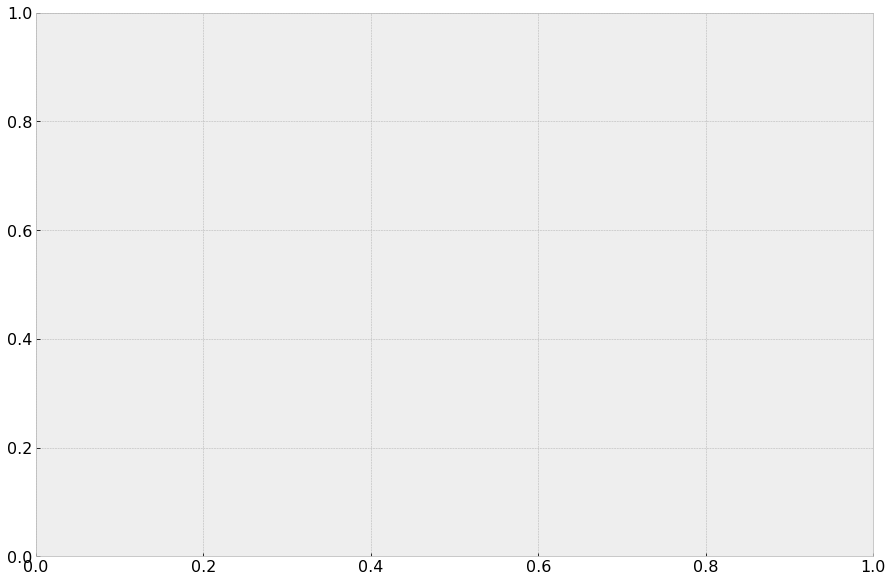

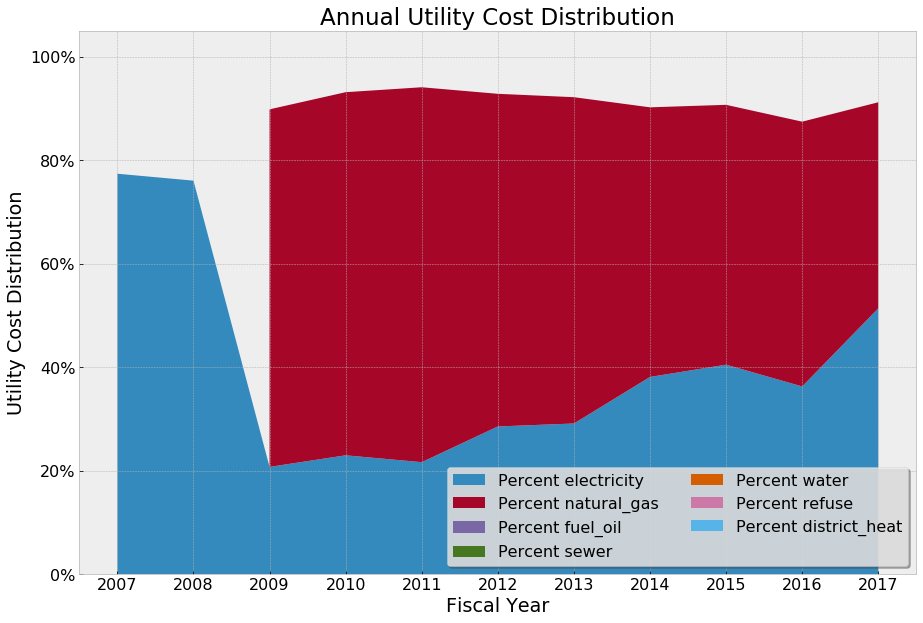

In [98]:
# Reset the index so the fiscal year column can be passed to the graphing utility
reset_df2 = df2.reset_index()

file_name = site + "_graph_pg3_g2.png"

utility_list = ['electricity', 'natural_gas', 'fuel_oil', 'sewer', 'water', 'refuse', 'district_heat']

gu.area_cost_distribution(reset_df2, 'fiscal_year', utility_list, file_name)

In [99]:
file_name2 = site + "_graph_pg3_g1.png"

gu.create_stacked_bar(reset_df2, 'fiscal_year', utility_list, file_name2)

TypeError: create_stacked_bar() missing 1 required positional argument: 'filename'

## Export Data to Dictionary

In [100]:
# Export the rows of the DataFrame into a list of dictionaries for use
# in the template.  Rename columns to match template variables.
row_dicts = bu.df_to_dictionaries(df2)
row_dicts

[{'district_heat': 0.0,
  'electricity': 54161.057878787855,
  'fiscal_year': 2017,
  'fuel_oil': nan,
  'hdd': 13802.0,
  'month_count': 12.0,
  'natural_gas': 41955.989017137101,
  'pct_change': 0.18103159987302431,
  'refuse': 0.0,
  'sewer': 4978.5462500000003,
  'total': 105418.75082449638,
  'water': 4323.1576785714287},
 {'district_heat': 0.0,
  'electricity': 32391.098484848484,
  'fiscal_year': 2016,
  'fuel_oil': nan,
  'hdd': 12171.0,
  'month_count': 12.0,
  'natural_gas': 45647.201628024202,
  'pct_change': -0.049375501617985096,
  'refuse': 0.0,
  'sewer': 6108.2274999999991,
  'total': 89259.890112872687,
  'water': 5113.3625000000011},
 {'district_heat': 0.0,
  'electricity': 38017.419166666674,
  'fiscal_year': 2015,
  'fuel_oil': nan,
  'hdd': 12393.0,
  'month_count': 12.0,
  'natural_gas': 47128.677258064497,
  'pct_change': -0.0013910368310102728,
  'refuse': 0.0,
  'sewer': 4593.0161666666672,
  'total': 93896.054924731172,
  'water': 4156.9423333333343},
 {'distr

In [104]:
# Put results into the final dictionary that will be passed to the Template.
# This assumes you have created a couple graphs with the file names shown below.
g1_url = 'images/{}_uco_g1.png'.format(site)
g2_url = 'images/{}_uco_g2.png'.format(site)
template_data['utility_cost_overview'] = dict(
    graphs=[g1_url, g2_url],
    table=dict(rows=row_dicts),
)
template_data

{'utility_cost_overview': {'graphs': ['images/ANSBG1_uco_g1.png',
   'images/ANSBG1_uco_g2.png'],
  'table': {'rows': [{'district_heat': 0.0,
     'electricity': 54161.057878787855,
     'fiscal_year': 2017,
     'fuel_oil': nan,
     'hdd': 13802.0,
     'month_count': 12.0,
     'natural_gas': 41955.989017137101,
     'pct_change': 0.18103159987302431,
     'refuse': 0.0,
     'sewer': 4978.5462500000003,
     'total': 105418.75082449638,
     'water': 4323.1576785714287},
    {'district_heat': 0.0,
     'electricity': 32391.098484848484,
     'fiscal_year': 2016,
     'fuel_oil': nan,
     'hdd': 12171.0,
     'month_count': 12.0,
     'natural_gas': 45647.201628024202,
     'pct_change': -0.049375501617985096,
     'refuse': 0.0,
     'sewer': 6108.2274999999991,
     'total': 89259.890112872687,
     'water': 5113.3625000000011},
    {'district_heat': 0.0,
     'electricity': 38017.419166666674,
     'fiscal_year': 2015,
     'fuel_oil': nan,
     'hdd': 12393.0,
     'month_count

## Convert the Notebook into a Script

In [46]:
# Convert the notebook to a script.
#!jupyter nbconvert --to script alan_report_pages.ipynb